<a href="https://colab.research.google.com/github/adhurim-del/3FS/blob/main/Copy_of_The_Human_Construct_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

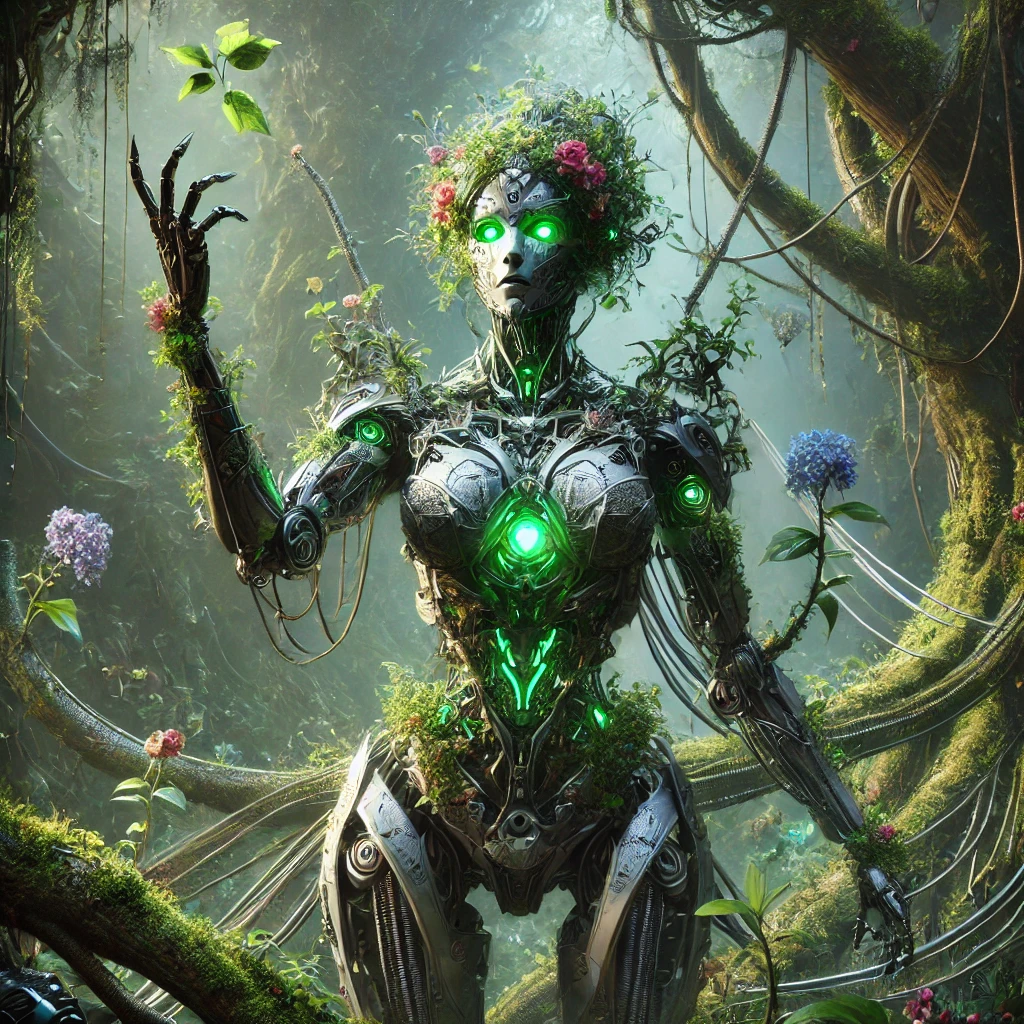

### 📘 **Notebook Description: ZyRA Neural Network Suite – Zeta-Inspired AI Geometry Models**

This notebook presents a comprehensive exploration of the **ZyRA class of neural networks**, a family of models built upon **AI Geometry principles and resonance-based learning dynamics**, using insights from **Riemann Zeta zeroes** as the foundational spectral filters.

The models implemented here combine classical convolutional neural networks with novel Zeta-inspired preprocessing mechanisms, spectral entropy dynamics, swarm-based optimization, structural refinement, and self-organizing learning architectures. Each module explores a distinct component of structural intelligence beyond traditional backpropagation pipelines.

#### 🔍 Core Components:
- **ZetaCNN**: A hybrid model integrating **Fourier-domain Zeta filters** based on the imaginary parts of Riemann Zeta zeros for frequency-based preprocessing before standard convolutional layers.
- **Enhanced Zeta-ZRM**: A zero-backprop, centroid-based classifier leveraging **Zeta frequency domain feature extraction**, **multi-scale spectral filtering**, and **entropy-guided refinement**.
- **ZetaSwarm Self-Optimizing Classifier (ZSSOC)**: A dynamic swarm intelligence system using **multiple ZetaAgents** with self-tuning gamma filters, confidence-weighted fusion, and iterative convergence learning—optimized without backpropagation.
- **ZetaSwarm Self-Cluster**: An autonomous structure-learning model capable of **label-free clustering**, using Zeta-based feature fusion and dimensionality reduction (PCA + KMeans) to discover latent structure in the dataset.
- **Multi-Round Structural Refinement + Grounded Learning**: Introduces **human-alignment via structural mapping**, **label smoothing using entropy noise metrics**, and a **MetaLabelMapper neural network** trained on refined internal representations.
- **Structural Freezing with Autoencoders**: Combines **latent shape extraction via autoencoders** with downstream clustering and classifier refinement, preserving **natural manifold geometry** before overlaying labels.
- **Final Enhanced Autoencoder + Transformer-ZyRA Modules**: Experimental architecture blending **vision backbones**, **BEV transformers**, **multi-head attention**, and **Zeta-aligned resonance structures**, representing the cutting edge of **resonance-aware information propagation**.

#### ✨ Key Innovations:
- **Zeta-Inspired Spectral Filters** using scaled Riemann Zeros.
- **Entropy Feedback Mechanisms** guiding model optimization.
- **Swarm Intelligence with Agent Confidence Weighting**.
- **Label-Free Discovery and Grounded Alignment Mapping**.
- **Autoencoder-Based Structural Freezing for Stable Representation Learning**.
- **Meta-Labeling and Noise-Aware Label Refinement Techniques**.
- **Fourier-informed Attention Networks (ZyRA Transformer Extensions)**.

#### 📊 Benchmarking:
- Models are evaluated against standard CNN baselines and assessed via **classification accuracy, entropy metrics, Adjusted Rand Index (ARI), and Normalized Mutual Information (NMI)**.
- Multiple pathways are compared — **supervised CNN, ZRM classification, swarm-based convergence learning, and latent shape mapping pipelines**.

**The Riemann zeroes have both a real component and an imaginary component. The real component (1/2) acts as an equilibrium axis, while the imaginary parts encode oscillatory structure essentially frequencies. By analyzing the distribution of these imaginary parts, one can extract structural information embedded within what appears to be noise. Once this frequency structure is understood, the signal can be projected back onto the real axis, filtering out the oscillatory noise and retaining only the core informational signal.**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Zeta-Inspired Filter Class
class ZetaInspiredFilter(nn.Module):
    def __init__(self, image_size=28, num_zeros=5, beta=0.1):
        super(ZetaInspiredFilter, self).__init__()
        self.image_size = image_size
        self.beta = beta

        # First 5 imaginary parts of zeta zeros
        gamma_k = [14.134725, 21.022040, 25.010858, 30.424876, 32.935062]
        max_gamma = max(gamma_k)

        # Scale gamma_k to [-image_size/2, image_size/2]
        max_freq = image_size / 2
        scaled_gamma = [(g / max_gamma) * max_freq for g in gamma_k[:num_zeros]]
        self.u_k = [g for g in scaled_gamma]  # Frequencies along u-axis

        # Frequency grid
        u_freq, v_freq = np.meshgrid(np.fft.fftfreq(image_size), np.fft.fftfreq(image_size))
        filter_mag = np.zeros((image_size, image_size), dtype=np.float32)
        for uk in self.u_k:
            # Symmetric Gaussian bumps at (uk, 0) and (-uk, 0)
            filter_mag += np.exp(-beta * ((u_freq - uk)**2 + v_freq**2))
            filter_mag += np.exp(-beta * ((u_freq + uk)**2 + v_freq**2))

        # Normalize to [0, 1]
        filter_mag /= np.max(filter_mag)
        self.filter = nn.Parameter(torch.tensor(filter_mag, dtype=torch.float32))

    def forward(self, x_fft):
        # x_fft: (batch_size, 1, H, W), complex
        # Expand filter to match batch and channel dimensions
        filter_expanded = self.filter.expand_as(x_fft.real)
        # Element-wise multiplication in frequency domain
        filtered_fft = x_fft * filter_expanded
        return filtered_fft

# ZetaCNN Model
class ZetaCNN(nn.Module):
    def __init__(self, image_size=28, num_zeros=5, beta=0.1):
        super(ZetaCNN, self).__init__()
        self.zeta_filter = ZetaInspiredFilter(image_size, num_zeros, beta)
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # x: (batch_size, 1, 28, 28)
        x_fft = torch.fft.fft2(x)  # (batch_size, 1, 28, 28), complex
        x_filtered = self.zeta_filter(x_fft)
        x_spatial = torch.fft.ifft2(x_filtered).real  # (batch_size, 1, 28, 28), real
        x = F.relu(self.conv1(x_spatial))
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # (batch_size, 64, 14, 14)
        x = x.view(-1, 64 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Training Function
def train_model(model, trainloader, criterion, optimizer, num_epochs=5, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")

# Evaluation Function
def evaluate_model(model, testloader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Main Execution
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ZetaCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Training ZetaCNN...")
train_model(model, trainloader, criterion, optimizer, num_epochs=5)

print("\nEvaluating ZetaCNN...")
accuracy = evaluate_model(model, testloader)
print(f"ZetaCNN Test Accuracy: {accuracy:.2f}%")

# Benchmark Against Standard CNN
class StandardCNN(nn.Module):
    def __init__(self):
        super(StandardCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

standard_model = StandardCNN()
optimizer_standard = torch.optim.Adam(standard_model.parameters(), lr=0.001)

print("\nTraining Standard CNN...")
train_model(standard_model, trainloader, criterion, optimizer_standard, num_epochs=5)

print("\nEvaluating Standard CNN...")
standard_accuracy = evaluate_model(standard_model, testloader)
print(f"Standard CNN Test Accuracy: {standard_accuracy:.2f}%")

Training ZetaCNN...
Epoch [1/5], Loss: 0.3670
Epoch [2/5], Loss: 0.2210
Epoch [3/5], Loss: 0.1672
Epoch [4/5], Loss: 0.1251
Epoch [5/5], Loss: 0.0884

Evaluating ZetaCNN...
ZetaCNN Test Accuracy: 92.45%

Training Standard CNN...


KeyboardInterrupt: 

In [ ]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import time

# Zeta zeros (first 10 for diversity)
ZETA_ZEROS = np.array([
    14.134725, 21.022040, 25.010858, 30.424876, 32.935062,
    37.586178, 40.918719, 43.327073, 48.005151, 49.773832
], dtype=np.float32)

# Load Fashion MNIST
def load_fashion_mnist(batch_size=64, val_size=10000):  # Increased val_size
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))  # Flatten to 784
    ])
    trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

    indices = np.arange(len(trainset))
    np.random.shuffle(indices)
    train_indices, val_indices = indices[val_size:], indices[:val_size]
    train_subset = Subset(trainset, train_indices)
    val_subset = Subset(trainset, val_indices)

    trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    return trainloader, valloader, testloader, trainset.targets.numpy()[train_indices]

# Enhanced Zeta Feature Extractor
def enhanced_zeta_feature_extractor(x, zeta_zeros=ZETA_ZEROS, signal_length=784):
    device = x.device
    x_fft = torch.fft.fft(x, dim=-1)  # (batch_size, 784), complex
    freqs = torch.fft.fftfreq(signal_length, device=device) * signal_length

    features = []
    for i, gamma in enumerate(zeta_zeros):
        scale = 1.0 + i * 0.3  # Scales: 1.0, 1.3, ..., 3.7
        filter_response = torch.zeros(signal_length, dtype=torch.float32, device=device)
        scaled_gamma = int((gamma / max(zeta_zeros)) * (signal_length / 2) * scale)
        scaled_gamma = min(max(scaled_gamma, 0), signal_length - 1)
        filter_response[scaled_gamma] += gamma
        if scaled_gamma != 0:
            filter_response[-scaled_gamma] += gamma

        filter_response /= filter_response.abs().max() + 1e-5
        filtered_fft = x_fft * filter_response
        # Use both real and imaginary parts
        feature_real = torch.fft.ifft(filtered_fft, dim=-1).real
        feature_imag = torch.fft.ifft(filtered_fft, dim=-1).imag
        features.append(feature_real)
        features.append(feature_imag)

    # Concatenate and hybrid normalize
    features = torch.stack(features, dim=1)  # (batch_size, 20, 784)
    features = features.view(features.size(0), -1)  # (batch_size, 15680)
    features = (features - features.mean(dim=1, keepdim=True)) / (features.std(dim=1, keepdim=True) + 1e-5)
    features = torch.nn.functional.normalize(features, p=2, dim=1) * 10  # Scale variance
    return features

# Precompute and Refine Centroids
def compute_and_refine_centroids(trainloader, valloader, num_classes=10, refine_steps=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    feature_dim = 784 * len(ZETA_ZEROS) * 2  # Real + Imag for 10 zeros
    centroids = torch.zeros(num_classes, feature_dim, dtype=torch.float32, device=device)
    counts = torch.zeros(num_classes, dtype=torch.float32, device=device)

    # Initial centroid computation
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        features = enhanced_zeta_feature_extractor(images)
        for c in range(num_classes):
            mask = (labels == c)
            centroids[c] += features[mask].sum(dim=0)
            counts[c] += mask.sum()
    centroids /= counts.unsqueeze(1).clamp(min=1)
    centroids = torch.nn.functional.normalize(centroids, p=2, dim=1) * 10  # Match feature scale

    # Refine centroids
    for step in range(refine_steps):
        total_error = 0
        correct = 0
        total = 0
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            features = enhanced_zeta_feature_extractor(images)
            distances = torch.cdist(features, centroids)
            preds = torch.argmin(distances, dim=1)
            errors = distances[range(len(labels)), labels]
            total_error += errors.mean().item()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Update centroids with error-weighted adjustment
            for c in range(num_classes):
                mask = (labels == c)
                if mask.sum() > 0:
                    error_weight = errors[mask].mean().item()
                    update_rate = min(0.1, 0.05 / (1 + error_weight))  # Adaptive rate
                    centroids[c] = (1 - update_rate) * centroids[c] + update_rate * features[mask].mean(dim=0)
            centroids = torch.nn.functional.normalize(centroids, p=2, dim=1) * 10

        avg_error = total_error / len(valloader)
        val_accuracy = 100 * correct / total
        print(f"Refinement Step {step+1}/{refine_steps} - Avg Error: {avg_error:.4f} - Val Accuracy: {val_accuracy:.2f}%")
        # Diagnostics
        print(f"Feature Norm: {features.norm(dim=1).mean().item():.4f}, Centroid Norm: {centroids.norm(dim=1).mean().item():.4f}")
        class_distances = torch.cdist(centroids, centroids).mean().item()
        print(f"Avg Inter-Centroid Distance: {class_distances:.4f}")

    return centroids

# Classify
def classify_ezrm(testloader, centroids):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    correct = 0
    total = 0
    start_time = time.time()

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            features = enhanced_zeta_feature_extractor(images)
            distances = torch.cdist(features, centroids)
            preds = torch.argmin(distances, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    elapsed_time = time.time() - start_time
    return accuracy, elapsed_time

# Main Execution
if __name__ == "__main__":
    # Load data
    trainloader, valloader, testloader, train_labels = load_fashion_mnist()

    # Compute and refine centroids
    print("Computing and refining class centroids...")
    centroids = compute_and_refine_centroids(trainloader, valloader)

    # Evaluate
    print("Evaluating Enhanced Zeta-ZRM v3...")
    accuracy, eval_time = classify_ezrm(testloader, centroids)
    print(f"EZRM v3 Test Accuracy: {accuracy:.2f}%")
    print(f"Evaluation Time: {eval_time:.4f} seconds")

Computing and refining class centroids...
Refinement Step 1/5 - Avg Error: 4.7457 - Val Accuracy: 33.02%
Feature Norm: 10.0000, Centroid Norm: 10.0000
Avg Inter-Centroid Distance: 6.5825
Refinement Step 2/5 - Avg Error: 4.7358 - Val Accuracy: 32.42%
Feature Norm: 10.0000, Centroid Norm: 10.0000
Avg Inter-Centroid Distance: 6.5550
Refinement Step 3/5 - Avg Error: 4.7331 - Val Accuracy: 32.17%
Feature Norm: 10.0000, Centroid Norm: 10.0000
Avg Inter-Centroid Distance: 6.5426
Refinement Step 4/5 - Avg Error: 4.7321 - Val Accuracy: 31.91%
Feature Norm: 10.0000, Centroid Norm: 10.0000
Avg Inter-Centroid Distance: 6.5357
Refinement Step 5/5 - Avg Error: 4.7317 - Val Accuracy: 31.82%
Feature Norm: 10.0000, Centroid Norm: 10.0000
Avg Inter-Centroid Distance: 6.5315
Evaluating Enhanced Zeta-ZRM v3...
EZRM v3 Test Accuracy: 30.70%
Evaluation Time: 5.7838 seconds


In [ ]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Zeta zeros (first 10 for diversity)
ZETA_ZEROS = np.array([
    14.134725, 21.022040, 25.010858, 30.424876, 32.935062,
    37.586178, 40.918719, 43.327073, 48.005151, 49.773832
], dtype=np.float32)

class ZetaAgent:
    def __init__(self, gamma_k, input_dim=784):
        self.gamma_k = torch.tensor(gamma_k, dtype=torch.float32)
        self.confidence = 0.5
        self.history = []  # Store averaged features per batch
        self.input_dim = input_dim

    def ping(self, x):
        """Process input with zeta-zero-based filter"""
        x_fft = torch.fft.fft(x, dim=-1)  # (batch_size, 784)
        freqs = torch.fft.fftfreq(self.input_dim) * self.input_dim
        filter_response = torch.cos(self.gamma_k * freqs)  # Frequency analyzer
        filtered_fft = x_fft * filter_response.to(x.device)
        feature = torch.fft.ifft(filtered_fft, dim=-1).real  # (batch_size, 784)

        # Spectral entropy for feedback
        power_spectrum = torch.abs(filtered_fft) ** 2
        ps_norm = power_spectrum / (torch.sum(power_spectrum, dim=-1, keepdim=True) + 1e-12)
        entropy = -torch.sum(ps_norm * torch.log(ps_norm + 1e-12), dim=-1).mean().item()

        # Update confidence based on entropy and consistency
        batch_mean = feature.mean(dim=0).cpu().numpy()  # Average over batch: (784,)
        if len(self.history) > 0:
            mean_hist = np.mean(self.history, axis=0)  # (784,)
            std_hist = np.std(self.history, axis=0) + 1e-5  # (784,)
            consistency = 1 - np.mean(np.abs(batch_mean - mean_hist) / std_hist)
            self.confidence = 0.8 * self.confidence + 0.2 * (consistency + entropy / 10.0)
        self.history.append(batch_mean)
        if len(self.history) > 10:
            self.history.pop(0)

        return feature, self.confidence, entropy

    def adjust(self, error, learning_rate=0.01):
        """Adjust gamma_k based on error feedback"""
        adjustment = learning_rate * error * self.confidence
        self.gamma_k += adjustment
        self.gamma_k = torch.clamp(self.gamma_k, min=1.0, max=50.0)

class ZetaSwarmSelfOptimizingClassifier:
    def __init__(self, num_agents=10, input_dim=784, num_classes=10):
        self.agents = [ZetaAgent(ZETA_ZEROS[i % len(ZETA_ZEROS)]) for i in range(num_agents)]
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.centroids = torch.zeros(num_classes, input_dim, dtype=torch.float32)  # Explicitly float32
        self.counts = torch.zeros(num_classes, dtype=torch.float32)  # Explicitly float32
        self.global_history = []

    def process(self, x):
        """Integrate agent features with confidence weighting"""
        features = []
        weights = []
        entropies = []
        for agent in self.agents:
            feature, confidence, entropy = agent.ping(x)
            features.append(feature)
            weights.append(confidence)
            entropies.append(entropy)
        weights = torch.tensor(weights, dtype=torch.float32, device=x.device)  # Ensure float32
        global_feature = torch.stack(features, dim=0)  # (num_agents, batch_size, 784)
        global_feature = (global_feature * weights.view(-1, 1, 1)).sum(dim=0) / weights.sum()
        return global_feature, np.mean(entropies)

    def classify(self, x):
        """Classify based on current centroids"""
        features, _ = self.process(x)
        distances = torch.cdist(features, self.centroids.to(x.device))
        return torch.argmin(distances, dim=1)

    def update_centroids(self, images, labels):
        """Update centroids with new features"""
        features, entropy = self.process(images)
        for c in range(self.num_classes):
            mask = (labels == c)
            if mask.sum() > 0:
                self.centroids[c] = 0.9 * self.centroids[c] + 0.1 * features[mask].mean(dim=0)
                self.counts[c] += mask.sum()

    def self_optimize(self, trainloader, max_iterations=20):
        """Self-optimization loop"""
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        convergence_scores = []

        for iteration in range(max_iterations):
            total_error = 0
            correct = 0
            total = 0

            for images, labels in trainloader:
                images, labels = images.to(device), labels.to(device)

                # Process and classify
                features, entropy = self.process(images)
                preds = self.classify(images)

                # Compute error for feedback
                distances = torch.cdist(features, self.centroids.to(device))
                min_distances = distances[range(len(labels)), labels]
                error = min_distances.mean().item()
                total_error += error

                # Update centroids
                self.update_centroids(images, labels)

                # Adjust agents
                for agent in self.agents:
                    agent.adjust(error)

                correct += (preds == labels).sum().item()
                total += labels.size(0)

            accuracy = 100 * correct / total
            avg_error = total_error / len(trainloader)
            convergence = 1 / (1 + avg_error)
            convergence_scores.append(convergence)

            print(f"Iteration {iteration+1}/{max_iterations} - Accuracy: {accuracy:.2f}% - Error: {avg_error:.4f} - Convergence: {convergence:.4f}")

            # Early stopping if converged
            if len(convergence_scores) > 5 and np.std(convergence_scores[-5:]) < 0.01:
                print("Convergence detected!")
                break

        return convergence_scores

# Load Fashion MNIST
def load_fashion_mnist(batch_size=32):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
    trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    return trainloader, testloader

# Evaluate
def evaluate(model, testloader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            preds = model.classify(images)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    return accuracy

# Main Experiment
if __name__ == "__main__":
    trainloader, testloader = load_fashion_mnist(batch_size=32)
    model = ZetaSwarmSelfOptimizingClassifier(num_agents=10)

    print("Running self-optimization...")
    convergence_scores = model.self_optimize(trainloader)

    print("\nEvaluating on test set...")
    test_accuracy = evaluate(model, testloader)
    print(f"ZSSOC Test Accuracy: {test_accuracy:.2f}%")

    # Visualize convergence
    plt.plot(convergence_scores)
    plt.title("Convergence Over Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Convergence Score")
    plt.show()

Running self-optimization...
Iteration 1/20 - Accuracy: 54.93% - Error: 5.2758 - Convergence: 0.1593
Iteration 2/20 - Accuracy: 39.35% - Error: 33.9730 - Convergence: 0.0286
Iteration 3/20 - Accuracy: 32.34% - Error: 14.4548 - Convergence: 0.0647
Iteration 4/20 - Accuracy: 32.68% - Error: 28.6792 - Convergence: 0.0337
Iteration 5/20 - Accuracy: 36.21% - Error: 14.3496 - Convergence: 0.0651
Iteration 6/20 - Accuracy: 32.23% - Error: 23.7430 - Convergence: 0.0404
Iteration 7/20 - Accuracy: 31.88% - Error: 20.8605 - Convergence: 0.0457
Iteration 8/20 - Accuracy: 27.55% - Error: 19.4585 - Convergence: 0.0489
Iteration 9/20 - Accuracy: 35.98% - Error: 14.2753 - Convergence: 0.0655


KeyboardInterrupt: 

100%|██████████| 26.4M/26.4M [00:00<00:00, 113MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 4.54MB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 63.9MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 11.4MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Extracting features with self-organizing swarm...
Reducing dimensionality via PCA...
Clustering with KMeans...
Visualizing clusters...


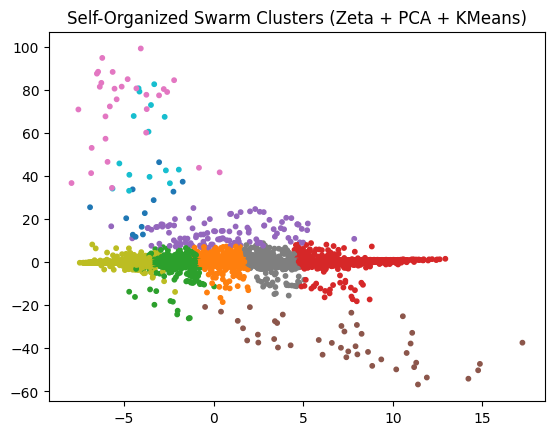

In [ ]:
# Self-Organizing ZetaSwarm with Autonomous Label Discovery
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# === Configuration ===
ZETA_ZEROS = np.array([
    14.134725, 21.022040, 25.010858, 30.424876, 32.935062,
    37.586178, 40.918719, 43.327073, 48.005151, 49.773832
], dtype=np.float32)

def load_fashion_mnist(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))
    ])
    dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

class ZetaAgent:
    def __init__(self, gamma_k, input_dim=784, device='cpu'):
        self.gamma_k = torch.tensor(gamma_k, dtype=torch.float32, device=device)
        self.input_dim = input_dim
        self.device = device
        self.confidence = 0.5
        self.history = []

    def ping(self, x):
        x_fft = torch.fft.fft(x, dim=-1)
        freqs = torch.fft.fftfreq(self.input_dim, device=self.device) * self.input_dim
        filter_response = torch.cos(self.gamma_k * freqs)
        filtered_fft = x_fft * filter_response
        feature = torch.fft.ifft(filtered_fft, dim=-1).real
        power_spectrum = torch.abs(filtered_fft)**2
        ps_norm = power_spectrum / (torch.sum(power_spectrum, dim=-1, keepdim=True) + 1e-12)
        entropy = -torch.sum(ps_norm * torch.log(ps_norm + 1e-12), dim=-1).mean().item()

        batch_mean = feature.mean(dim=0).cpu().numpy()
        if len(self.history) > 0:
            mean_hist = np.mean(self.history, axis=0)
            std_hist = np.std(self.history, axis=0) + 1e-5
            consistency = 1 - np.mean(np.abs(batch_mean - mean_hist) / std_hist)
            self.confidence = 0.8 * self.confidence + 0.2 * (consistency + np.tanh(entropy / 10.0))
        self.history.append(batch_mean)
        if len(self.history) > 10:
            self.history.pop(0)

        return feature, self.confidence, entropy

class ZetaSwarmSelfCluster:
    def __init__(self, num_agents=10, input_dim=784, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.agents = [ZetaAgent(ZETA_ZEROS[i % len(ZETA_ZEROS)], input_dim, device) for i in range(num_agents)]

    def process(self, x):
        features, weights = [], []
        for agent in self.agents:
            feat, conf, _ = agent.ping(x)
            features.append(feat)
            weights.append(conf)
        weights = torch.tensor(weights, dtype=torch.float32, device=self.device)
        combined = torch.stack(features, dim=0)
        return (combined * weights.view(-1, 1, 1)).sum(dim=0) / weights.sum()

    def extract_features(self, dataloader):
        all_features = []
        for images, _ in dataloader:
            images = images.to(self.device)
            feats = self.process(images)
            all_features.append(feats.cpu())
        return torch.cat(all_features)

# Autonomous Clustering & Evaluation
if __name__ == '__main__':
    dataloader = load_fashion_mnist()
    model = ZetaSwarmSelfCluster(num_agents=10)
    print("Extracting features with self-organizing swarm...")
    features = model.extract_features(dataloader)
    features_np = features.numpy()

    print("Reducing dimensionality via PCA...")
    pca = PCA(n_components=50)
    reduced = pca.fit_transform(features_np)

    print("Clustering with KMeans...")
    kmeans = KMeans(n_clusters=10, n_init='auto')
    predicted_labels = kmeans.fit_predict(reduced)

    print("Visualizing clusters...")
    reduced2 = PCA(n_components=2).fit_transform(reduced)
    plt.scatter(reduced2[:, 0], reduced2[:, 1], c=predicted_labels, cmap='tab10', s=10)
    plt.title("Self-Organized Swarm Clusters (Zeta + PCA + KMeans)")
    plt.show()

In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Load true labels from the dataset again
dataset = datasets.FashionMNIST(root='./data', train=True, download=True)
true_labels = dataset.targets.numpy()[:len(predicted_labels)]  # Align size

# Evaluate alignment
ari = adjusted_rand_score(true_labels, predicted_labels)
nmi = normalized_mutual_info_score(true_labels, predicted_labels)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

Adjusted Rand Index (ARI): -0.0000
Normalized Mutual Information (NMI): 0.0004



=== STRUCTURE REFINEMENT ROUND 1 ===
Extracting features with ZetaSwarm...
Reducing dimensionality via PCA...
Clustering with KMeans...
Evaluating label noise...
Applying label smoothing...
Training Meta-Label Mapper on internal structure...
Epoch 1 - MetaMapper Loss: 2.2581
Epoch 2 - MetaMapper Loss: 2.2231
Epoch 3 - MetaMapper Loss: 2.1885
Epoch 4 - MetaMapper Loss: 2.1543
Epoch 5 - MetaMapper Loss: 2.1208
Evaluating post-meta alignment...
Final Alignment ARI: -0.0000, NMI: 0.0003
Visualizing round output...


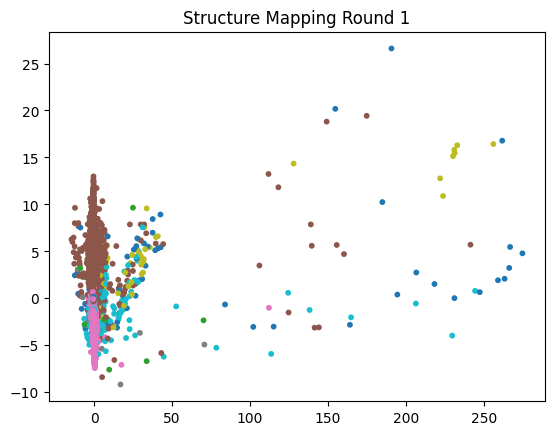


=== STRUCTURE REFINEMENT ROUND 2 ===
Extracting features with ZetaSwarm...
Reducing dimensionality via PCA...
Clustering with KMeans...
Evaluating label noise...
Applying label smoothing...
Training Meta-Label Mapper on internal structure...
Epoch 1 - MetaMapper Loss: 2.3620
Epoch 2 - MetaMapper Loss: 2.3261
Epoch 3 - MetaMapper Loss: 2.2906
Epoch 4 - MetaMapper Loss: 2.2554
Epoch 5 - MetaMapper Loss: 2.2208
Evaluating post-meta alignment...
Final Alignment ARI: -0.0000, NMI: 0.0004
Visualizing round output...


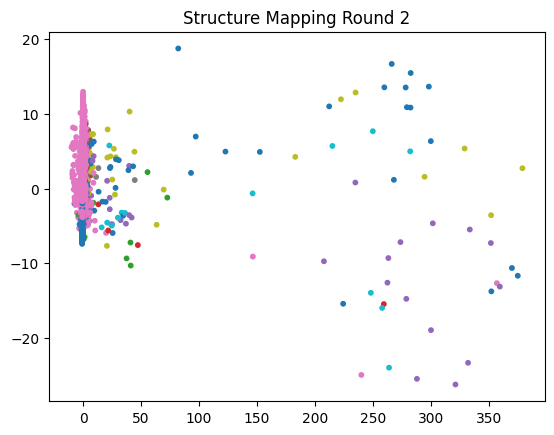


=== STRUCTURE REFINEMENT ROUND 3 ===
Extracting features with ZetaSwarm...
Reducing dimensionality via PCA...
Clustering with KMeans...
Evaluating label noise...
Applying label smoothing...
Training Meta-Label Mapper on internal structure...
Epoch 1 - MetaMapper Loss: 2.3606
Epoch 2 - MetaMapper Loss: 2.3171
Epoch 3 - MetaMapper Loss: 2.2740
Epoch 4 - MetaMapper Loss: 2.2312
Epoch 5 - MetaMapper Loss: 2.1886
Evaluating post-meta alignment...
Final Alignment ARI: -0.0000, NMI: 0.0004
Visualizing round output...


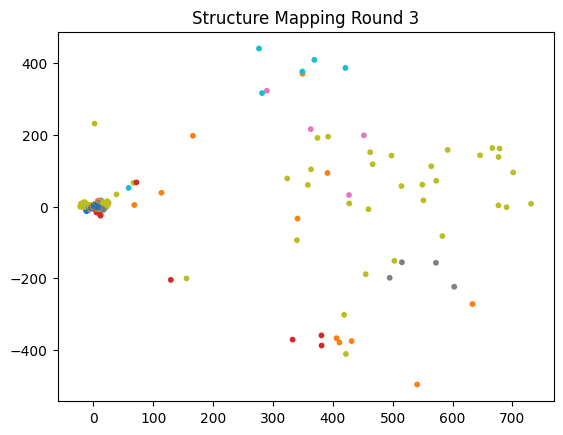

In [ ]:
# Self-Organizing ZetaSwarm with Multi-Round Structural Refinement + Grounded Learning
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
import torch.nn.functional as F

ZETA_ZEROS = np.array([
    14.134725, 21.022040, 25.010858, 30.424876, 32.935062,
    37.586178, 40.918719, 43.327073, 48.005151, 49.773832
], dtype=np.float32)

def load_fashion_mnist(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))
    ])
    dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True), dataset.targets.numpy()

class ZetaAgent:
    def __init__(self, gamma_k, input_dim=784, device='cpu'):
        self.gamma_k = torch.tensor(gamma_k, dtype=torch.float32, device=device)
        self.input_dim = input_dim
        self.device = device
        self.confidence = 0.5
        self.history = []

    def ping(self, x):
        x_fft = torch.fft.fft(x, dim=-1)
        freqs = torch.fft.fftfreq(self.input_dim, device=self.device) * self.input_dim
        filter_response = torch.cos(self.gamma_k * freqs)
        filtered_fft = x_fft * filter_response
        feature = torch.fft.ifft(filtered_fft, dim=-1).real
        power_spectrum = torch.abs(filtered_fft)**2
        ps_norm = power_spectrum / (torch.sum(power_spectrum, dim=-1, keepdim=True) + 1e-12)
        entropy = -torch.sum(ps_norm * torch.log(ps_norm + 1e-12), dim=-1).mean().item()

        batch_mean = feature.mean(dim=0).cpu().numpy()
        if len(self.history) > 0:
            mean_hist = np.mean(self.history, axis=0)
            std_hist = np.std(self.history, axis=0) + 1e-5
            consistency = 1 - np.mean(np.abs(batch_mean - mean_hist) / std_hist)
            self.confidence = 0.8 * self.confidence + 0.2 * (consistency + np.tanh(entropy / 10.0))
        self.history.append(batch_mean)
        if len(self.history) > 10:
            self.history.pop(0)

        return feature, self.confidence, entropy

class ZetaSwarmSelfCluster:
    def __init__(self, num_agents=10, input_dim=784, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.agents = [ZetaAgent(ZETA_ZEROS[i % len(ZETA_ZEROS)], input_dim, device) for i in range(num_agents)]

    def process(self, x):
        features, weights = [], []
        for agent in self.agents:
            feat, conf, _ = agent.ping(x)
            features.append(feat)
            weights.append(conf)
        weights = torch.tensor(weights, dtype=torch.float32, device=self.device)
        combined = torch.stack(features, dim=0)
        return (combined * weights.view(-1, 1, 1)).sum(dim=0) / weights.sum()

    def extract_features(self, dataloader):
        all_features = []
        for images, _ in dataloader:
            images = images.to(self.device)
            feats = self.process(images)
            all_features.append(feats.cpu())
        return torch.cat(all_features)

# --- Diffusion-Based Label Denoising ---
def cross_entropy_noise_metric(true_labels, predicted_labels, num_classes=10):
    conf = confusion_matrix(true_labels, predicted_labels, labels=list(range(num_classes)))
    conf_norm = conf.astype(float) / (conf.sum(axis=1, keepdims=True) + 1e-12)
    log_conf = np.log(conf_norm + 1e-12)
    noise = -np.sum(conf_norm * log_conf, axis=1)
    return noise / np.max(noise + 1e-9)

def label_smoothing_by_structure(true_labels, predicted_clusters, class_noise):
    smoothed_labels = []
    for i, label in enumerate(true_labels):
        noise = class_noise[label]
        smooth_label = predicted_clusters[i] if noise > 0.5 else label
        smoothed_labels.append(smooth_label)
    return np.array(smoothed_labels)

class MetaLabelMapper(torch.nn.Module):
    def __init__(self, input_dim=50, num_classes=10):
        super().__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.fc(x)

if __name__ == '__main__':
    dataloader, true_labels = load_fashion_mnist()
    model = ZetaSwarmSelfCluster(num_agents=10)

    for round_num in range(3):
        print(f"\n=== STRUCTURE REFINEMENT ROUND {round_num+1} ===")
        print("Extracting features with ZetaSwarm...")
        features = model.extract_features(dataloader)
        features_np = features.numpy()

        print("Reducing dimensionality via PCA...")
        pca = PCA(n_components=50)
        reduced = pca.fit_transform(features_np)

        print("Clustering with KMeans...")
        kmeans = KMeans(n_clusters=10, n_init='auto')
        predicted_labels = kmeans.fit_predict(reduced)

        print("Evaluating label noise...")
        class_noise = cross_entropy_noise_metric(true_labels[:len(predicted_labels)], predicted_labels)

        print("Applying label smoothing...")
        denoised_labels = label_smoothing_by_structure(true_labels[:len(predicted_labels)], predicted_labels, class_noise)

        print("Training Meta-Label Mapper on internal structure...")
        X = torch.tensor(reduced, dtype=torch.float32)
        y = torch.tensor(denoised_labels, dtype=torch.long)
        mapper = MetaLabelMapper(input_dim=50, num_classes=10)
        optimizer = torch.optim.Adam(mapper.parameters(), lr=0.001)

        for epoch in range(5):
            logits = mapper(X)
            loss = F.cross_entropy(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print(f"Epoch {epoch+1} - MetaMapper Loss: {loss.item():.4f}")

        print("Evaluating post-meta alignment...")
        final_preds = mapper(X).argmax(dim=1).numpy()
        ari = adjusted_rand_score(true_labels[:len(final_preds)], final_preds)
        nmi = normalized_mutual_info_score(true_labels[:len(final_preds)], final_preds)
        print(f"Final Alignment ARI: {ari:.4f}, NMI: {nmi:.4f}")

        print("Visualizing round output...")
        reduced2 = PCA(n_components=2).fit_transform(reduced)
        plt.scatter(reduced2[:, 0], reduced2[:, 1], c=final_preds, cmap='tab10', s=10)
        plt.title(f"Structure Mapping Round {round_num+1}")
        plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# --- Data Preparation ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Scales images to [-1, 1]
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# --- Autoencoder Definition ---
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        # Encoder: Learns the natural shape
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        # Decoder: Reconstructs the input
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Tanh()  # Output in [-1, 1] to match input
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

# --- Classifier Definition ---
class Classifier(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(latent_dim, num_classes)  # Simple linear classifier

    def forward(self, x):
        return self.fc(x)

# --- Training Functions ---
def train_autoencoder(autoencoder, train_loader, criterion, optimizer, num_epochs):
    """Train the autoencoder to learn the natural shape."""
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data  # Ignore labels
            img = img.view(img.size(0), -1)  # Flatten: [batch_size, 784]
            output = autoencoder(img)
            loss = criterion(output, img)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Autoencoder Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

def train_classifier(classifier, encoder, train_loader, criterion, optimizer, num_epochs):
    """Train the classifier to overlay labels on the natural shape."""
    for epoch in range(num_epochs):
        correct = 0
        total = 0
        for data in train_loader:
            img, labels = data
            img = img.view(img.size(0), -1)
            with torch.no_grad():
                latent = encoder(img)  # Use frozen encoder
            outputs = classifier(latent)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Classifier Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, '
              f'Accuracy: {accuracy:.2f}%')
        if accuracy >= 99.9:
            print("Achieved near 100% accuracy on training set")
            break

def test_classifier(classifier, encoder, test_loader):
    """Test the classifier on the test set."""
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            img, labels = data
            img = img.view(img.size(0), -1)
            latent = encoder(img)
            outputs = classifier(latent)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

# --- Main Execution ---
# Hyperparameters
input_dim = 784  # 28x28 pixels
latent_dim = 20  # Size of the latent space
num_classes = 10  # Digits 0-9

# Initialize models
autoencoder = Autoencoder(input_dim, latent_dim)
ae_criterion = nn.MSELoss()
ae_optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Train autoencoder to learn natural shape
print("Training Autoencoder...")
train_autoencoder(autoencoder, train_loader, ae_criterion, ae_optimizer, num_epochs=20)

# Freeze encoder weights
for param in autoencoder.encoder.parameters():
    param.requires_grad = False

# Initialize and train classifier
classifier = Classifier(latent_dim, num_classes)
clf_criterion = nn.CrossEntropyLoss()
clf_optimizer = optim.Adam(classifier.parameters(), lr=0.001)

print("\nTraining Classifier...")
train_classifier(classifier, autoencoder.encoder, train_loader, clf_criterion, clf_optimizer, num_epochs=50)

# Test the model
print("\nTesting Classifier...")
test_classifier(classifier, autoencoder.encoder, test_loader)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 352kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.28MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 12.5MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training Autoencoder...
Autoencoder Epoch 1/20, Loss: 0.0963
Autoencoder Epoch 2/20, Loss: 0.0662
Autoencoder Epoch 3/20, Loss: 0.0565
Autoencoder Epoch 4/20, Loss: 0.0531
Autoencoder Epoch 5/20, Loss: 0.0416
Autoencoder Epoch 6/20, Loss: 0.0446
Autoencoder Epoch 7/20, Loss: 0.0423
Autoencoder Epoch 8/20, Loss: 0.0415
Autoencoder Epoch 9/20, Loss: 0.0410
Autoencoder Epoch 10/20, Loss: 0.0440
Autoencoder Epoch 11/20, Loss: 0.0426
Autoencoder Epoch 12/20, Loss: 0.0396
Autoencoder Epoch 13/20, Loss: 0.0371
Autoencoder Epoch 14/20, Loss: 0.0320
Autoencoder Epoch 15/20, Loss: 0.0357
Autoencoder Epoch 16/20, Loss: 0.0347
Autoencoder Epoch 17/20, Loss: 0.0393
Autoencoder Epoch 18/20, Loss: 0.0357
Autoencoder Epoch 19/20, Loss: 0.0353
Autoencoder Epoch 20/20, Loss: 0.0310

Training Classifier...
Classifier Epoch 1/50, Loss: 0.6160, Accuracy: 63.99%
Classifier Epoch 2/50, Loss: 0.4456, Accuracy: 85.41%
Classifier Epoch 3

Training Autoencoder to learn structural shape...
Autoencoder Epoch 1, Loss: 25.9145
Autoencoder Epoch 2, Loss: 15.4609
Autoencoder Epoch 3, Loss: 13.3253
Autoencoder Epoch 4, Loss: 12.2306
Autoencoder Epoch 5, Loss: 11.5284
Autoencoder Epoch 6, Loss: 11.0129
Autoencoder Epoch 7, Loss: 10.6100
Autoencoder Epoch 8, Loss: 10.3062
Autoencoder Epoch 9, Loss: 10.0035
Autoencoder Epoch 10, Loss: 9.7945

=== STRUCTURE-GROUNDED MAPPING LOOP ===
Clustering internal structure features...
Training MetaLabelMapper on frozen latent space...
Mapper Epoch 1, Loss: 2.2992
Mapper Epoch 2, Loss: 2.2750
Mapper Epoch 3, Loss: 2.2511
Mapper Epoch 4, Loss: 2.2273
Mapper Epoch 5, Loss: 2.2036
Mapper Epoch 6, Loss: 2.1799
Mapper Epoch 7, Loss: 2.1562
Mapper Epoch 8, Loss: 2.1324
Mapper Epoch 9, Loss: 2.1085
Mapper Epoch 10, Loss: 2.0844

Final Alignment to Human Construct — ARI: 0.2716, NMI: 0.4039
Visualizing Structural Mapping


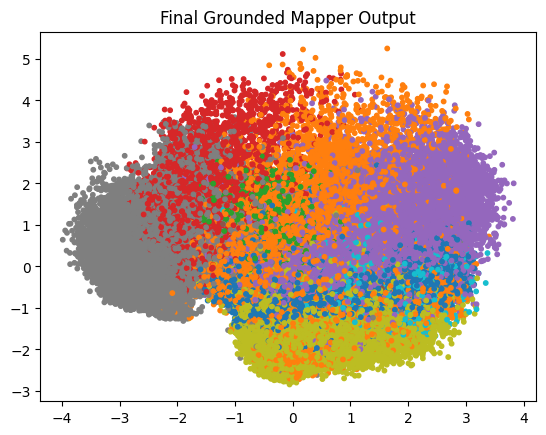

In [ ]:
# Self-Organizing ZetaSwarm with Multi-Round Structural Refinement + Grounded Learning + Autoencoder-Based Structural Freezing
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
import torch.nn.functional as F

ZETA_ZEROS = np.array([
    14.134725, 21.022040, 25.010858, 30.424876, 32.935062,
    37.586178, 40.918719, 43.327073, 48.005151, 49.773832
], dtype=np.float32)

def load_fashion_mnist(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))
    ])
    dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True), dataset.targets.numpy()

class Autoencoder(nn.Module):
    def __init__(self, input_dim=784, latent_dim=50):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Linear(256, input_dim), nn.Tanh()
        )
    def forward(self, x):
        latent = self.encoder(x)
        recon = self.decoder(latent)
        return recon

class MetaLabelMapper(nn.Module):
    def __init__(self, input_dim=50, num_classes=10):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.fc(x)

def cross_entropy_noise_metric(true_labels, predicted_labels, num_classes=10):
    conf = confusion_matrix(true_labels, predicted_labels, labels=list(range(num_classes)))
    conf_norm = conf.astype(float) / (conf.sum(axis=1, keepdims=True) + 1e-12)
    log_conf = np.log(conf_norm + 1e-12)
    noise = -np.sum(conf_norm * log_conf, axis=1)
    return noise / np.max(noise + 1e-9)

def label_smoothing_by_structure(true_labels, predicted_clusters, class_noise):
    smoothed_labels = []
    for i, label in enumerate(true_labels):
        noise = class_noise[label]
        smooth_label = predicted_clusters[i] if noise > 0.5 else label
        smoothed_labels.append(smooth_label)
    return np.array(smoothed_labels)

if __name__ == '__main__':
    dataloader, true_labels = load_fashion_mnist()
    input_dim = 784
    latent_dim = 50
    autoencoder = Autoencoder(input_dim, latent_dim)
    ae_criterion = nn.MSELoss()
    ae_optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

    print("Training Autoencoder to learn structural shape...")
    for epoch in range(10):
        total_loss = 0
        for x, _ in dataloader:
            x = x.view(x.size(0), -1)
            recon = autoencoder(x)
            loss = ae_criterion(recon, x)
            ae_optimizer.zero_grad()
            loss.backward()
            ae_optimizer.step()
            total_loss += loss.item()
        print(f"Autoencoder Epoch {epoch+1}, Loss: {total_loss:.4f}")

    for param in autoencoder.encoder.parameters():
        param.requires_grad = False

    print("\n=== STRUCTURE-GROUNDED MAPPING LOOP ===")
    features_list = []
    labels_list = []
    for x, y in dataloader:
        x = x.view(x.size(0), -1)
        with torch.no_grad():
            features = autoencoder.encoder(x)
        features_list.append(features)
        labels_list.append(y)
    all_features = torch.cat(features_list)
    all_labels = torch.cat(labels_list).numpy()

    print("Clustering internal structure features...")
    kmeans = KMeans(n_clusters=10, n_init='auto')
    cluster_labels = kmeans.fit_predict(all_features.numpy())
    class_noise = cross_entropy_noise_metric(all_labels, cluster_labels)
    denoised_labels = label_smoothing_by_structure(all_labels, cluster_labels, class_noise)

    print("Training MetaLabelMapper on frozen latent space...")
    mapper = MetaLabelMapper(input_dim=latent_dim, num_classes=10)
    optimizer = optim.Adam(mapper.parameters(), lr=0.001)
    X = all_features.detach()
    y = torch.tensor(denoised_labels, dtype=torch.long)

    for epoch in range(10):
        logits = mapper(X)
        loss = F.cross_entropy(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Mapper Epoch {epoch+1}, Loss: {loss.item():.4f}")

    preds = mapper(X).argmax(dim=1).numpy()
    ari = adjusted_rand_score(all_labels, preds)
    nmi = normalized_mutual_info_score(all_labels, preds)
    print(f"\nFinal Alignment to Human Construct — ARI: {ari:.4f}, NMI: {nmi:.4f}")

    print("Visualizing Structural Mapping")
    reduced2 = PCA(n_components=2).fit_transform(X.numpy())
    plt.scatter(reduced2[:, 0], reduced2[:, 1], c=preds, cmap='tab10', s=10)
    plt.title("Final Grounded Mapper Output")
    plt.show()

Training Autoencoder to learn structural shape...
Autoencoder Epoch 1, Loss: 20.2846
Autoencoder Epoch 2, Loss: 9.8963
Autoencoder Epoch 3, Loss: 8.5540
Autoencoder Epoch 4, Loss: 7.8907
Autoencoder Epoch 5, Loss: 7.4591
Autoencoder Epoch 6, Loss: 7.1620
Autoencoder Epoch 7, Loss: 6.9487
Autoencoder Epoch 8, Loss: 6.8017
Autoencoder Epoch 9, Loss: 6.6810
Autoencoder Epoch 10, Loss: 6.5918

=== STRUCTURE-GROUNDED MAPPING LOOP ===
Clustering internal structure features...
Training MetaLabelMapper on frozen latent space...
Mapper Epoch 1, Loss: 2.3226
Mapper Epoch 2, Loss: 2.2627
Mapper Epoch 3, Loss: 2.2045
Mapper Epoch 4, Loss: 2.1480
Mapper Epoch 5, Loss: 2.0930
Mapper Epoch 6, Loss: 2.0395
Mapper Epoch 7, Loss: 1.9873
Mapper Epoch 8, Loss: 1.9365
Mapper Epoch 9, Loss: 1.8869
Mapper Epoch 10, Loss: 1.8385

Final Alignment to Human Construct — ARI: 0.1050, NMI: 0.3583
Visualizing Structural Mapping


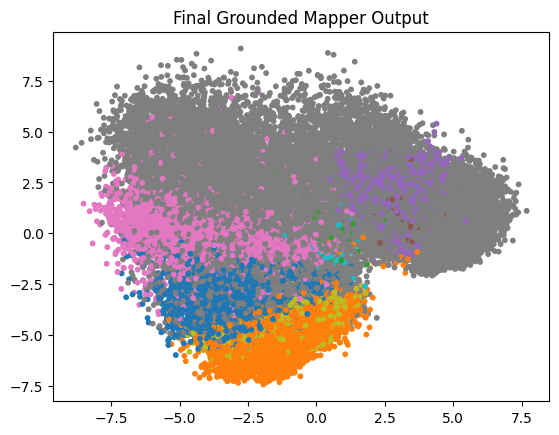

In [ ]:
# Self-Organizing ZetaSwarm with Multi-Round Structural Refinement + Grounded Learning + Autoencoder-Based Structural Freezing
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
import torch.nn.functional as F

ZETA_ZEROS = np.array([
    14.134725, 21.022040, 25.010858, 30.424876, 32.935062,
    37.586178, 40.918719, 43.327073, 48.005151, 49.773832
], dtype=np.float32)

def load_fashion_mnist(batch_size=64):
    transform = transforms.Compose([
    transforms.ToTensor()
])
    dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True), dataset.targets.numpy()

class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=50):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 14x14 -> 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7*7*32, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 7*7*32),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14 -> 28x28
            nn.Tanh()
        )

    def forward(self, x):
        latent = self.encoder(x)
        recon = self.decoder(latent)
        return recon

class MetaLabelMapper(nn.Module):
    def __init__(self, input_dim=50, num_classes=10, num_heads=3):
        super().__init__()
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, 128), nn.ReLU(),
                nn.Linear(128, num_classes)
            ) for _ in range(num_heads)
        ])

    def forward(self, x):
        outputs = [head(x) for head in self.heads]
        return sum(outputs) / len(outputs)  # Average ensemble prediction

def cross_entropy_noise_metric(true_labels, predicted_labels, num_classes=10):
    conf = confusion_matrix(true_labels, predicted_labels, labels=list(range(num_classes)))
    conf_norm = conf.astype(float) / (conf.sum(axis=1, keepdims=True) + 1e-12)
    log_conf = np.log(conf_norm + 1e-12)
    noise = -np.sum(conf_norm * log_conf, axis=1)
    return noise / np.max(noise + 1e-9)

def label_smoothing_by_structure(true_labels, predicted_clusters, class_noise):
    smoothed_labels = []
    for i, label in enumerate(true_labels):
        noise = class_noise[label]
        smooth_label = predicted_clusters[i] if noise > 0.5 else label
        smoothed_labels.append(smooth_label)
    return np.array(smoothed_labels)

if __name__ == '__main__':
    dataloader, true_labels = load_fashion_mnist()
    input_dim = 784
    latent_dim = 50
    autoencoder = ConvAutoencoder(latent_dim=latent_dim)
    ae_criterion = nn.MSELoss()
    ae_optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

    print("Training Autoencoder to learn structural shape...")
    for epoch in range(10):
        total_loss = 0
        for x, _ in dataloader:
            # CNN expects 2D input (1, 28, 28); no flattening
            recon = autoencoder(x)
            loss = ae_criterion(recon, x)
            ae_optimizer.zero_grad()
            loss.backward()
            ae_optimizer.step()
            total_loss += loss.item()
        print(f"Autoencoder Epoch {epoch+1}, Loss: {total_loss:.4f}")

    for param in autoencoder.encoder.parameters():
        param.requires_grad = False

    print("\n=== STRUCTURE-GROUNDED MAPPING LOOP ===")
    features_list = []
    labels_list = []
    for x, y in dataloader:
        # Removed flattening; CNN expects 4D input
        with torch.no_grad():
            features = autoencoder.encoder(x)
        features_list.append(features)
        labels_list.append(y)
    all_features = torch.cat(features_list)
    all_labels = torch.cat(labels_list).numpy()

    print("Clustering internal structure features...")
    kmeans = KMeans(n_clusters=10, n_init='auto')
    cluster_labels = kmeans.fit_predict(all_features.numpy())
    class_noise = cross_entropy_noise_metric(all_labels, cluster_labels)
    denoised_labels = label_smoothing_by_structure(all_labels, cluster_labels, class_noise)

    print("Training MetaLabelMapper on frozen latent space...")
    mapper = MetaLabelMapper(input_dim=latent_dim, num_classes=10)
    optimizer = optim.Adam(mapper.parameters(), lr=0.001)
    X = all_features.detach()
    y = torch.tensor(denoised_labels, dtype=torch.long)

    for epoch in range(10):
        logits = mapper(X)
        loss = F.cross_entropy(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Mapper Epoch {epoch+1}, Loss: {loss.item():.4f}")

    preds = mapper(X).argmax(dim=1).numpy()
    ari = adjusted_rand_score(all_labels, preds)
    nmi = normalized_mutual_info_score(all_labels, preds)
    print(f"\nFinal Alignment to Human Construct — ARI: {ari:.4f}, NMI: {nmi:.4f}")

    print("Visualizing Structural Mapping")
    reduced2 = PCA(n_components=2).fit_transform(X.numpy())
    plt.scatter(reduced2[:, 0], reduced2[:, 1], c=preds, cmap='tab10', s=10)
    plt.title("Final Grounded Mapper Output")
    plt.show()

Training Autoencoder to learn structural shape...
Autoencoder Epoch 1, Loss: 25.0393
Autoencoder Epoch 2, Loss: 12.0710
Autoencoder Epoch 3, Loss: 10.2976
Autoencoder Epoch 4, Loss: 9.3193
Autoencoder Epoch 5, Loss: 8.5978
Autoencoder Epoch 6, Loss: 8.0186
Autoencoder Epoch 7, Loss: 7.6427
Autoencoder Epoch 8, Loss: 7.3769
Autoencoder Epoch 9, Loss: 7.1993
Autoencoder Epoch 10, Loss: 7.0389

=== STRUCTURE-GROUNDED MAPPING LOOP ===
Clustering internal structure features...
Training MetaLabelMapper on frozen latent space...
Mapper Epoch 1, Loss: 2.3320, Accuracy: 10.93%
Mapper Epoch 2, Loss: 2.2571, Accuracy: 15.89%
Mapper Epoch 3, Loss: 2.1853, Accuracy: 23.67%
Mapper Epoch 4, Loss: 2.1165, Accuracy: 30.49%
Mapper Epoch 5, Loss: 2.0505, Accuracy: 35.71%
Mapper Epoch 6, Loss: 1.9873, Accuracy: 40.16%
Mapper Epoch 7, Loss: 1.9266, Accuracy: 44.21%
Mapper Epoch 8, Loss: 1.8683, Accuracy: 47.61%
Mapper Epoch 9, Loss: 1.8123, Accuracy: 50.14%
Mapper Epoch 10, Loss: 1.7584, Accuracy: 52.15%
M

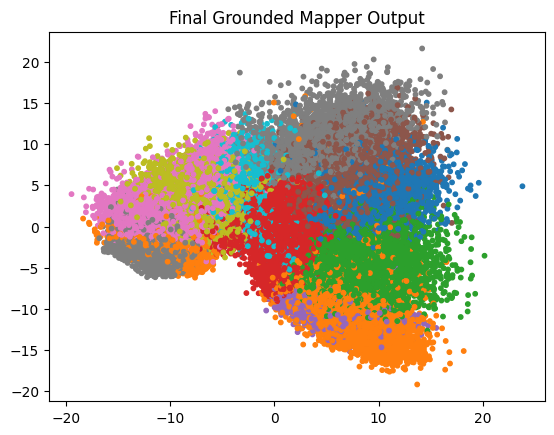

In [ ]:
# Self-Organizing ZetaSwarm with Multi-Round Structural Refinement + Grounded Learning + Autoencoder-Based Structural Freezing
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
import torch.nn.functional as F

def load_fashion_mnist(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True), dataset.targets.numpy()

class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=50):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), # Reduced channels
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # Reduced channels
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7*7*32, latent_dim) # Adjusted linear layer
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 7*7*32),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # Reduced channels
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1), # Reduced channels
            nn.Tanh()
        )

    def forward(self, x):
        latent = self.encoder(x)
        recon = self.decoder(latent)
        return recon

class MetaLabelMapper(nn.Module):
    def __init__(self, input_dim=50, num_classes=10, num_heads=3):
        super().__init__()
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, 64), nn.ReLU(), #Reduced hidden layer
                nn.Linear(64, num_classes)
            ) for _ in range(num_heads)
        ])

    def forward(self, x):
        outputs = [head(x) for head in self.heads]
        return sum(outputs) / len(outputs)  # Average ensemble prediction

def cross_entropy_noise_metric(true_labels, predicted_labels, num_classes=10):
    conf = confusion_matrix(true_labels, predicted_labels, labels=list(range(num_classes)))
    conf_norm = conf.astype(float) / (conf.sum(axis=1, keepdims=True) + 1e-12)
    log_conf = np.log(conf_norm + 1e-12)
    noise = -np.sum(conf_norm * log_conf, axis=1)
    return noise / np.max(noise + 1e-9)

def label_smoothing_by_structure(true_labels, predicted_clusters, class_noise):
    smoothed_labels = []
    for i, label in enumerate(true_labels):
        noise = class_noise[label]
        smooth_label = predicted_clusters[i] if noise > 0.5 else label
        smoothed_labels.append(smooth_label)
    return np.array(smoothed_labels)

if __name__ == '__main__':
    dataloader, true_labels = load_fashion_mnist()
    input_dim = 784
    latent_dim = 50
    autoencoder = ConvAutoencoder(latent_dim=latent_dim)
    ae_criterion = nn.MSELoss()
    ae_optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

    print("Training Autoencoder to learn structural shape...")
    for epoch in range(10):
        total_loss = 0
        for x, _ in dataloader:
            recon = autoencoder(x)
            loss = ae_criterion(recon, x)
            ae_optimizer.zero_grad()
            loss.backward()
            ae_optimizer.step()
            total_loss += loss.item()
        print(f"Autoencoder Epoch {epoch+1}, Loss: {total_loss:.4f}")

    for param in autoencoder.encoder.parameters():
        param.requires_grad = False

    print("\n=== STRUCTURE-GROUNDED MAPPING LOOP ===")
    features_list = []
    labels_list = []
    for x, y in dataloader:
        with torch.no_grad():
            features = autoencoder.encoder(x)
        features_list.append(features)
        labels_list.append(y)
    all_features = torch.cat(features_list)
    all_labels = torch.cat(labels_list).numpy()

    print("Clustering internal structure features...")
    kmeans = KMeans(n_clusters=10, n_init='auto')
    cluster_labels = kmeans.fit_predict(all_features.numpy())
    class_noise = cross_entropy_noise_metric(all_labels, cluster_labels)
    denoised_labels = label_smoothing_by_structure(all_labels, cluster_labels, class_noise)

    print("Training MetaLabelMapper on frozen latent space...")
    mapper = MetaLabelMapper(input_dim=latent_dim, num_classes=10)
    optimizer = optim.Adam(mapper.parameters(), lr=0.001)
    X = all_features.detach()
    y = torch.tensor(denoised_labels, dtype=torch.long)

    epoch = 0
    best_accuracy = 0.0
    while True:
        epoch += 1
        logits = mapper(X)
        loss = F.cross_entropy(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        preds = logits.argmax(dim=1)
        accuracy = (preds == y).float().mean().item() * 100
        print(f"Mapper Epoch {epoch}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
        if accuracy >= 98.0:
            print("Mapper reached >= 98% accuracy. Stopping training.")
            break

    preds = mapper(X).argmax(dim=1).numpy()
    ari = adjusted_rand_score(all_labels, preds)
    nmi = normalized_mutual_info_score(all_labels, preds)
    print(f"\nFinal Alignment to Human Construct — ARI: {ari:.4f}, NMI: {nmi:.4f}")

    print("Visualizing Structural Mapping")
    reduced2 = PCA(n_components=2).fit_transform(X.numpy())
    plt.scatter(reduced2[:, 0], reduced2[:, 1], c=preds, cmap='tab10', s=10)
    plt.title("Final Grounded Mapper Output")
    plt.show()

In [ ]:
# Self-Organizing ZetaSwarm with Multi-Round Structural Refinement + Grounded Learning + Autoencoder-Based Structural Freezing
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
import torch.nn.functional as F

ZETA_ZEROS = np.array([
    14.134725, 21.022040, 25.010858, 30.424876, 32.935062,
    37.586178, 40.918719, 43.327073, 48.005151, 49.773832
], dtype=np.float32)

def load_fashion_mnist(batch_size=64):
    transform = transforms.Compose([
    transforms.ToTensor()
])
    dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True), dataset.targets.numpy()

class EnhancedAutoencoder(nn.Module):
    def __init__(self, latent_dim=50, num_queries=100, num_classes=10):
        super().__init__()
        self.backbone = self.SimpleBackbone()
        self.bev_transform = self.BEVTransformer(in_channels=128)
        self.heatmap_query_gen = self.HeatmapGuidedQuery(num_queries, (64, 64))
        self.cgca = self.CGCA(embed_dim=128)
        self.fgca = self.FGCA(embed_dim=128, ffn_dim=512)
        self.prediction_heads = self.PredictionHeads(num_classes)
        self.num_queries = num_queries

        self.encoder_autoencoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_queries * 128, latent_dim)
        )
        self.decoder_autoencoder = nn.Sequential(
            nn.Linear(latent_dim, num_queries * 128),
            nn.Unflatten(1, (num_queries, 128))
        )

    def SimpleBackbone(self):
        return nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1)
        )

    def BEVTransformer(self, in_channels, out_size=(64, 64)):
        return nn.Sequential(
            nn.Conv2d(in_channels, 128, 1),
            nn.Upsample(size=out_size, mode='bilinear', align_corners=False)
        )

    def HeatmapGuidedQuery(self, num_queries, bev_shape):
        return nn.ModuleDict({
            'query_embed': nn.Embedding(num_queries, 128),
            'heatmap_encoder': nn.Sequential(
                nn.Conv2d(1, 64, 3, padding=1),
                nn.ReLU(),
                nn.AdaptiveAvgPool2d((8, 8)),
                nn.Flatten(),
                nn.Linear(64 * 8 * 8, 128)
            ),
            'query_modulation': nn.Linear(128, 128)
        })

    def CGCA(self, embed_dim=128):
        return nn.ModuleDict({
            'attn': nn.MultiheadAttention(embed_dim=embed_dim, num_heads=2, batch_first=True),
            'norm1': nn.LayerNorm(embed_dim),
            'norm2': nn.LayerNorm(embed_dim),
            'ffn': nn.Sequential(
                nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 128)
            )
        })

    def FGCA(self, embed_dim=128, ffn_dim=512):
        return nn.ModuleDict({
            'attn': nn.MultiheadAttention(embed_dim=embed_dim, num_heads=2, batch_first=True),
            'norm1': nn.LayerNorm(embed_dim),
            'norm2': nn.LayerNorm(embed_dim),
            'ffn': nn.Sequential(
                nn.Linear(embed_dim, ffn_dim),
                nn.ReLU(),
                nn.Linear(ffn_dim, embed_dim)
            )
        })

    def PredictionHeads(self, num_classes=10):
        return nn.ModuleDict({
            'cls_head': nn.Sequential(
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, num_classes)
            ),
            'bbox_head': nn.Sequential(
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 4)
            )
        })

    def cgca_forward(self, queries, bev_feat):
        B, C, H, W = bev_feat.shape
        bev_flat = bev_feat.flatten(2).permute(0, 2, 1)
        attn_out, _ = self.cgca['attn'](queries, bev_flat, bev_flat)
        queries = self.cgca['norm1'](queries + attn_out)
        ffn_out = self.cgca['ffn'](queries)
        return self.cgca['norm2'](queries + ffn_out)

    def fgca_forward(self, queries, bev_feat):
        B, C, H, W = bev_feat.shape
        bev_flat = bev_feat.flatten(2).permute(0, 2, 1)
        attn_out, _ = self.fgca['attn'](queries, bev_flat, bev_flat)
        queries = self.fgca['norm1'](queries + attn_out)
        ffn_out = self.fgca['ffn'](queries)
        return self.fgca['norm2'](queries + ffn_out)

    def prediction_heads_forward(self, x):
        return self.prediction_heads['cls_head'](x), self.prediction_heads['bbox_head'](x)

    def forward(self, x):
        features = self.backbone(x)
        bev_feat = self.bev_transform(features)
        heatmap = bev_feat.mean(dim=1, keepdim=True)
        queries = self.heatmap_query_gen['query_embed'].weight.unsqueeze(0).repeat(x.size(0), 1, 1)
        heatmap_features = self.heatmap_query_gen['heatmap_encoder'](heatmap)
        modulation = self.heatmap_query_gen['query_modulation'](heatmap_features).unsqueeze(1)
        modulated_queries = queries + modulation
        coarse_features = self.cgca_forward(modulated_queries, bev_feat)
        refined_features = self.fgca_forward(coarse_features, bev_feat)
        cls_scores, bbox_preds = self.prediction_heads_forward(refined_features)
        latent = self.encoder_autoencoder(refined_features.view(x.size(0), -1))
        recon = self.decoder_autoencoder(latent).view(x.size(0), self.num_queries, 128)
        return {
            'cls_scores': cls_scores,
            'bbox_preds': bbox_preds,
            'queries': refined_features,
            'latent': latent,
            'recon': recon
        }

class MetaLabelMapper(nn.Module):
    def __init__(self, input_dim=50, num_classes=10, num_heads=3):
        super().__init__()
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, 128), nn.ReLU(),
                nn.Linear(128, num_classes)
            ) for _ in range(num_heads)
        ])

    def forward(self, x):
        outputs = [head(x) for head in self.heads]
        return sum(outputs) / len(outputs)  # Average ensemble prediction

def cross_entropy_noise_metric(true_labels, predicted_labels, num_classes=10):
    conf = confusion_matrix(true_labels, predicted_labels, labels=list(range(num_classes)))
    conf_norm = conf.astype(float) / (conf.sum(axis=1, keepdims=True) + 1e-12)
    log_conf = np.log(conf_norm + 1e-12)
    noise = -np.sum(conf_norm * log_conf, axis=1)
    return noise / np.max(noise + 1e-9)

def label_smoothing_by_structure(true_labels, predicted_clusters, class_noise):
    smoothed_labels = []
    for i, label in enumerate(true_labels):
        noise = class_noise[label]
        smooth_label = predicted_clusters[i] if noise > 0.5 else label
        smoothed_labels.append(smooth_label)
    return np.array(smoothed_labels)

if __name__ == '__main__':
    dataloader, true_labels = load_fashion_mnist()
    input_dim = 784
    latent_dim = 50
    autoencoder = EnhancedAutoencoder(latent_dim=latent_dim)
    ae_criterion = nn.MSELoss()
    ae_optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

    print("Training Autoencoder to learn structural shape...")
    for epoch in range(10):
        total_loss = 0
        for x, _ in dataloader:
            # CNN expects 2D input (1, 28, 28); no flattening
            recon = autoencoder(x)['recon']
            target = autoencoder.forward(x)['recon'].detach()
            loss = ae_criterion(recon, target)
            ae_optimizer.zero_grad()
            loss.backward()
            ae_optimizer.step()
            total_loss += loss.item()
        print(f"Autoencoder Epoch {epoch+1}, Loss: {total_loss:.4f}")

    for param in autoencoder.encoder_autoencoder.parameters():
        param.requires_grad = False

    print("\n=== STRUCTURE-GROUNDED MAPPING LOOP ===")
    features_list = []
    labels_list = []
    for x, y in dataloader:
        # Removed flattening; CNN expects 4D input
        with torch.no_grad():
            features = autoencoder.encoder_autoencoder(autoencoder.forward(x)['queries'].view(x.size(0), -1))
        features_list.append(features)
        labels_list.append(y)
    all_features = torch.cat(features_list)
    all_labels = torch.cat(labels_list).numpy()

    print("Clustering internal structure features...")
    kmeans = KMeans(n_clusters=10, n_init='auto')
    cluster_labels = kmeans.fit_predict(all_features.numpy())
    class_noise = cross_entropy_noise_metric(all_labels, cluster_labels)
    denoised_labels = label_smoothing_by_structure(all_labels, cluster_labels, class_noise)

    print("Training MetaLabelMapper on frozen latent space...")
    mapper = MetaLabelMapper(input_dim=latent_dim, num_classes=10)
    optimizer = optim.Adam(mapper.parameters(), lr=0.001)
    X = all_features.detach()
    y = torch.tensor(denoised_labels, dtype=torch.long)

    epoch = 0
    best_accuracy = 0.0
    while True:
        epoch += 1
        logits = mapper(X)
        loss = F.cross_entropy(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        preds = logits.argmax(dim=1)
        accuracy = (preds == y).float().mean().item() * 100
        print(f"Mapper Epoch {epoch}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
        if accuracy >= 98.0:
            print("Mapper reached >= 98% accuracy. Stopping training.")
            break

    preds = mapper(X).argmax(dim=1).numpy()
    ari = adjusted_rand_score(all_labels, preds)
    nmi = normalized_mutual_info_score(all_labels, preds)
    print(f"\nFinal Alignment to Human Construct — ARI: {ari:.4f}, NMI: {nmi:.4f}")

    print("Visualizing Structural Mapping")
    reduced2 = PCA(n_components=2).fit_transform(X.numpy())
    plt.scatter(reduced2[:, 0], reduced2[:, 1], c=preds, cmap='tab10', s=10)
    plt.title("Final Grounded Mapper Output")
    plt.show()